In [2]:
import pandas as pd
import numpy as np
import ast

# 单步法按batch合并数据

In [2]:
data1 = pd.read_excel('data_stage3/one_step_attack_total1000_1016/one_step_attack_total1000_1016_1.xlsx')
data2 = pd.read_excel('data_stage3/one_step_attack_total1000_1016/one_step_attack_total1000_1016_2.xlsx')
data3 = pd.read_excel('data_stage3/one_step_attack_total1000_1107/one_step_attack_total1000_LRP_1107.xlsx')

In [3]:
# data = pd.read_excel('data_stage3/one_step_attack_total1000_1016/one_step_attack_total1000_1016.xlsx')
data = pd.concat([data1, data2, data3], axis=0)
data = data[data['model'] == 'vgg16']
data.head()

model  algo mask_mode  parameter    eta  pixel_attacked  \
1200  vgg16  fgsm  positive        NaN  0.005           75287   
1201  vgg16  fgsm  positive        NaN  0.010           75287   
1202  vgg16  fgsm  positive        NaN  0.015           75287   
1203  vgg16  fgsm  positive        NaN  0.020           75287   
1204  vgg16  fgsm  positive        NaN  0.025           75287   

      attack_ratio_per_channel  l1_norm   l2_norm  success_rate  \
1200  [0.4999, 0.5001, 0.5004]  85.1958  0.009553          0.38   
1201  [0.4999, 0.5001, 0.5004]  85.1958  0.009553          0.60   
1202  [0.4999, 0.5001, 0.5004]  85.1958  0.009553          0.73   
1203  [0.4999, 0.5001, 0.5004]  85.1958  0.009553          0.80   
1204  [0.4999, 0.5001, 0.5004]  85.1958  0.009553          0.83   

      original_loss  attack_loss  pred_loss  run_time  batch_idx  \
1200          0.212        1.037   0.637979     1.996          1   
1201          0.212        2.151   1.063958     1.996          1   
1202          0.212        3.105   1.489936     1.996          1   
1203          0.212        3.866   1.915915     1.996          1   
1204          0.212        4.467   2.341894     1.996          1   

      batch_pictures  
1200             100  
1201             100  
1202             100  
1203             100  
1204             100

In [4]:
def mean_of_lists(series):
    # 将每个元素转换为 NumPy 数组，然后计算均值
    arrays = np.array(series.tolist(), dtype=float)
    return np.mean(arrays, axis=0).tolist()

def calculate_eta_reverse(row):
    if row['mask_mode'] in ('cam_lowr', 'lowr', 'seed_randomr_lowr', 'channel_lowr','lrp_lowr'):
        return 1 - row['parameter']
    else:
        return row['parameter']

def l1_norm(series):
    return series.abs().sum()

def l2_norm(series):
    return np.sqrt((series ** 2).sum())

def merge_batch_onestep(data): 
    '''将多个batch的数据合并''' 
    data['parameter'] = data['parameter'].fillna(-1)
    data['attack_ratio_per_channel'] = data['attack_ratio_per_channel'].apply(ast.literal_eval)
    li = ['model', 'algo', 'mask_mode', 'parameter', 'eta']
    data_grouped = data.groupby(li).agg({
        'pixel_attacked': lambda x: int(x.mean()),
        'attack_ratio_per_channel': mean_of_lists,
        'l1_norm': l1_norm,
        'l2_norm': l2_norm,
        'original_loss'	: 'mean',
        'attack_loss': 'mean',
        'pred_loss': 'mean',
        'success_rate': lambda x: round(x.mean(), 4),
        'run_time': 'sum',
        'batch_pictures': 'sum', 
    }).reset_index()
    data_grouped[['R', 'G', 'B']] = pd.DataFrame(data_grouped['attack_ratio_per_channel'].tolist(), index=data_grouped.index)
    data_grouped['parameter0'] = data_grouped.apply(calculate_eta_reverse, axis=1)
    data_grouped.drop('attack_ratio_per_channel', axis=1, inplace=True)
    return data_grouped

In [5]:
data_grouped = merge_batch_onestep(data)
print(data_grouped.shape)

(1050, 18)


In [6]:
data_grouped.head()

model  algo mask_mode  parameter    eta  pixel_attacked    l1_norm  \
0  vgg16  fgsm       all       -1.0  0.005          150528  1533.9703   
1  vgg16  fgsm       all       -1.0  0.010          150528  1533.9703   
2  vgg16  fgsm       all       -1.0  0.015          150528  1533.9703   
3  vgg16  fgsm       all       -1.0  0.020          150528  1533.9703   
4  vgg16  fgsm       all       -1.0  0.025          150528  1533.9703   

    l2_norm  original_loss  attack_loss  pred_loss  success_rate  run_time  \
0  0.062196          0.161       1.9961   0.927985         0.551    19.767   
1  0.062196          0.161       3.8269   1.694970         0.783    19.767   
2  0.062196          0.161       4.9938   2.461955         0.876    19.767   
3  0.062196          0.161       5.7147   3.228940         0.917    19.767   
4  0.062196          0.161       6.1731   3.995926         0.927    19.767   

   batch_pictures    R    G    B  parameter0  
0            1000  1.0  1.0  1.0        -1.0  
1            1000  1.0  1.0  1.0        -1.0  
2            1000  1.0  1.0  1.0        -1.0  
3            1000  1.0  1.0  1.0        -1.0  
4            1000  1.0  1.0  1.0        -1.0

In [7]:
data_grouped.to_excel('./data_stage3/one_step_attack_total1000_1107/one_step_attack_total1000_1107vgg16_grouped.xlsx', index=False)

# 结果分析

In [3]:
data_grouped = pd.read_excel('./data_stage3/one_step_attack_total1000_1107/one_step_attack_total1000_1107vgg16_grouped.xlsx')

In [4]:
data_grouped.shape

(1050, 18)

In [5]:
data_root = './data_stage3/one_step_attack_total1000_1107'

In [11]:
for column in data_grouped.columns:
    if column not in ('l1_norm', 'l2_norm', 'success_rate','pixel_attacked', 'run_time',  'R', 'G', 'B'):
        unique_values = data_grouped[column].unique()
        print(f"字段 '{column}' 的唯一值: {unique_values}")
print(data_grouped.columns)


字段 'model' 的唯一值: ['vgg16']
字段 'algo' 的唯一值: ['fgsm']
字段 'mask_mode' 的唯一值: ['all' 'cam_lowr' 'cam_topr' 'channel_lowr' 'channel_topr' 'lowr'
 'lrp_lowr' 'lrp_topr' 'negative' 'positive' 'seed_randomr'
 'seed_randomr_lowr' 'topr']
字段 'parameter' 的唯一值: [-1.    0.01  0.02  0.03  0.04  0.05  0.06  0.07  0.08  0.09  0.1   0.11
  0.12  0.13  0.14  0.15  0.16  0.17  0.18  0.19  0.2   0.21  0.22  0.23
  0.24  0.25  0.26  0.27  0.28  0.29  0.3   0.31  0.32  0.33  0.34  0.35
  0.36  0.37  0.38  0.39  0.4   0.41  0.42  0.43  0.44  0.45  0.46  0.47
  0.48  0.49  0.5   0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59
  0.6   0.61  0.62  0.63  0.64  0.65  0.66  0.67  0.68  0.69  0.7   0.71
  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79  0.8   0.81  0.82  0.83
  0.84  0.85  0.86  0.87  0.88  0.89  0.9   0.91  0.92  0.93  0.94  0.95
  0.96  0.97  0.98  0.99]
字段 'eta' 的唯一值: [0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1  ]
字段 '

# 画图分析

In [6]:
from tools.show_result_one_step import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

data_grouped = pd.read_excel('./data_stage3/one_step_attack_total1000_1107/one_step_attack_total1000_1107vgg16_grouped.xlsx')

data_root = './data_stage3/one_step_attack_total1000_1107'

In [7]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print("Available fonts:", font_list)

# 使用第一个找到的中文字体
font_path = next((f for f in font_list if 'SimHei' in f or 'SimSun' in f or 'wqy' in f), None)

Available fonts: ['/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc', '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf']


In [8]:
font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'  # 显示中文字体

if not os.path.exists(font_path):
    print(f"字体文件 {font_path} 未找到。请确保字体文件存在于工作目录中。")
else:
    # 创建FontProperties对象
    font_prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = font_prop.get_name()


## 1. success_rate vs model&algo
- 只考虑mask_mode in ('all','negative','positive')

In [6]:
data1 = data_grouped[data_grouped['mask_mode'].isin(['all','negative','positive'])]
data1.head()

model  algo mask_mode  parameter    eta  pixel_attacked    l1_norm  \
0  vgg16  fgsm       all       -1.0  0.005          150528  1533.9703   
1  vgg16  fgsm       all       -1.0  0.010          150528  1533.9703   
2  vgg16  fgsm       all       -1.0  0.015          150528  1533.9703   
3  vgg16  fgsm       all       -1.0  0.020          150528  1533.9703   
4  vgg16  fgsm       all       -1.0  0.025          150528  1533.9703   

    l2_norm  original_loss  attack_loss  pred_loss  success_rate  run_time  \
0  0.062196          0.161       1.9961   0.927985         0.551    19.767   
1  0.062196          0.161       3.8269   1.694970         0.783    19.767   
2  0.062196          0.161       4.9938   2.461955         0.876    19.767   
3  0.062196          0.161       5.7147   3.228940         0.917    19.767   
4  0.062196          0.161       6.1731   3.995926         0.927    19.767   

   batch_pictures    R    G    B  parameter0  
0            1000  1.0  1.0  1.0        -1.0  
1            1000  1.0  1.0  1.0        -1.0  
2            1000  1.0  1.0  1.0        -1.0  
3            1000  1.0  1.0  1.0        -1.0  
4            1000  1.0  1.0  1.0        -1.0

### 1.1 成功率 and  loss vs eta

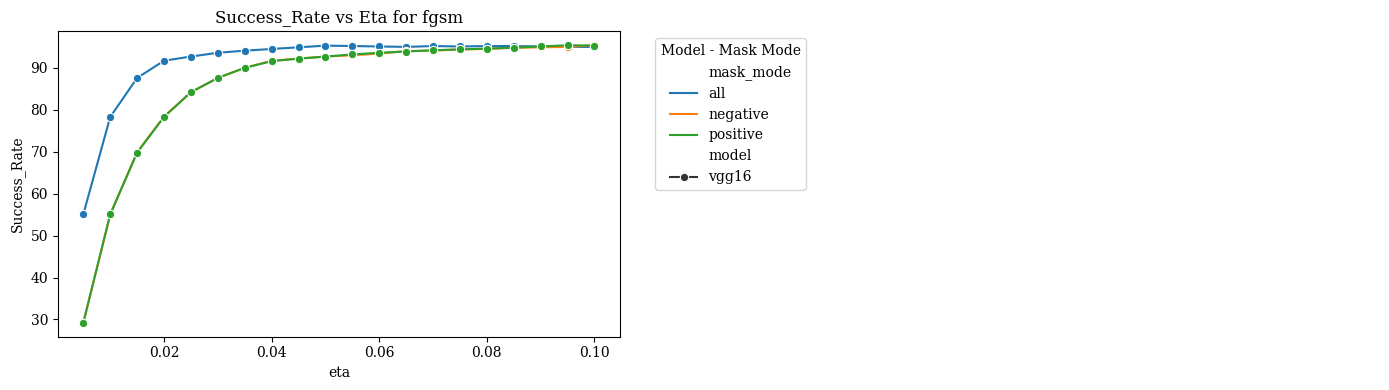

In [12]:
plot_success_rate_vs_eta(data1, algo_list=['fgsm'], var_list=['success_rate'], output_path=data_root, save_name='success_rate_vs_eta_gauss', ncols=2,nrows=1)

findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
findfont: Font family 'WenQuanYi Zen Hei' not found.
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25915 (\N{CJK UNIFIED IDEOGRAPH-653B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20987 (\N{CJK UNIFIED IDEOGRAPH-51FB}) missing from fon

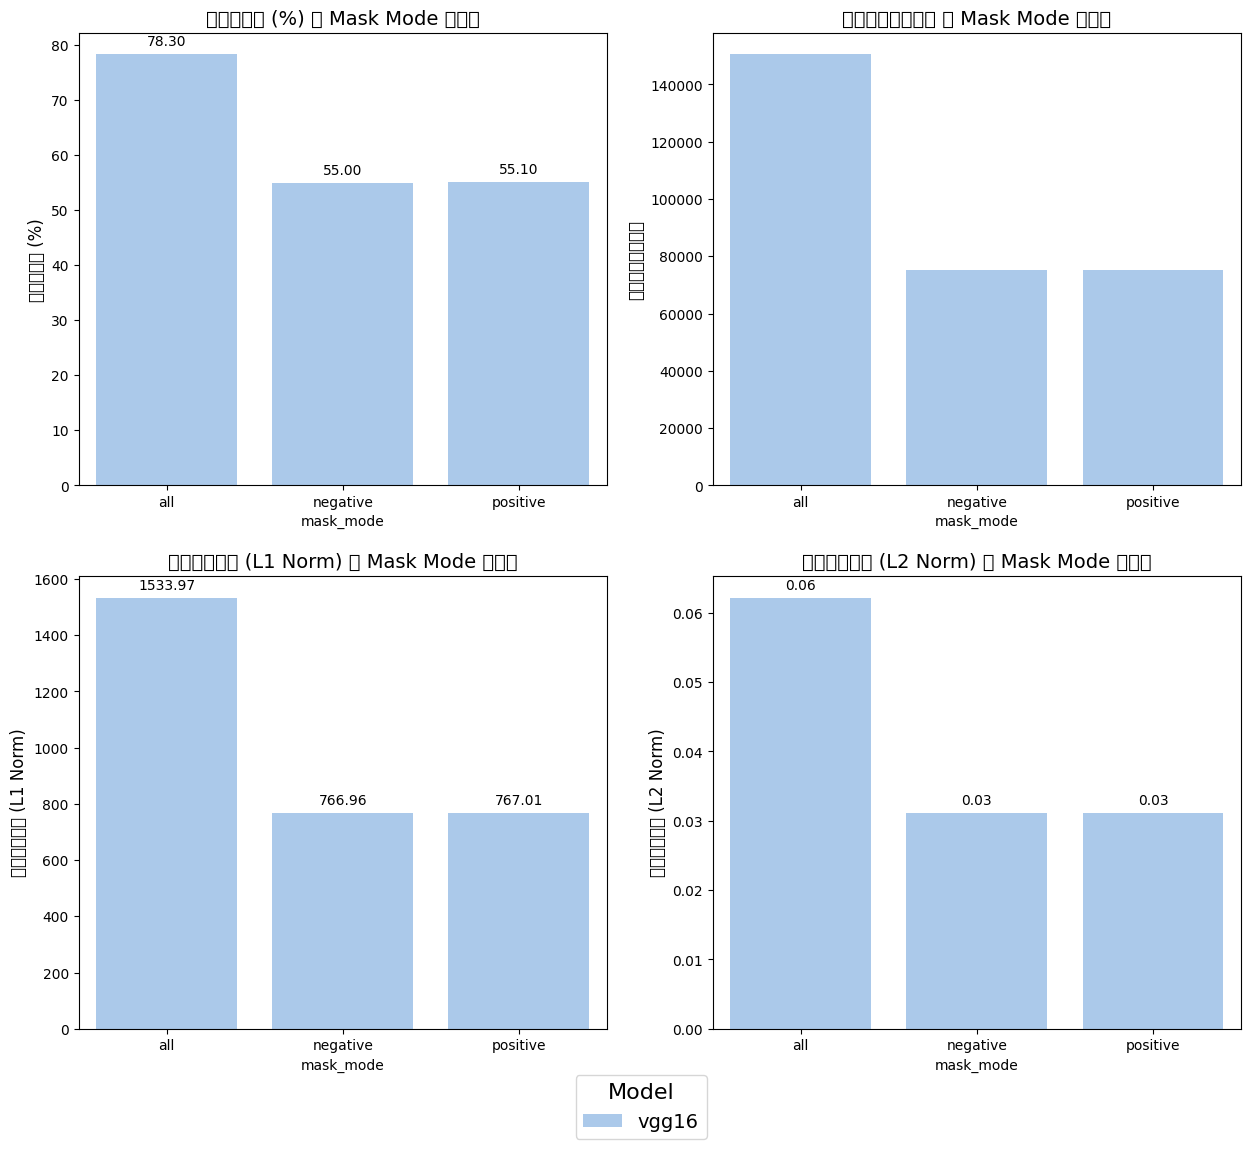

In [7]:
plot_success_rate_vs_norm(data1, 'fgsm', 0.01)

# 2. success_rate vs r
- 只考虑mask_mode in ['topr', 'channel_topr', 'cam_topr', 'channel_lowr', 'cam_lowr', 'lowr', 'seed_randomr_lowr', 'seed_randomr', 'lrp_topr', 'lrp_lowr']

In [9]:
data2 = data_grouped[data_grouped['mask_mode'].isin(['topr', 'channel_topr', 'cam_topr', 'channel_lowr', 'cam_lowr', 'lowr', 'seed_randomr_lowr', 'seed_randomr', 'lrp_topr', 'lrp_lowr'])]
data2.head()

model  algo mask_mode  parameter   eta  pixel_attacked  l1_norm   l2_norm  \
20  vgg16  fgsm  cam_lowr       0.01  0.01            1503  17.1591  0.000995   
21  vgg16  fgsm  cam_lowr       0.02  0.01            3009  33.3807  0.001830   
22  vgg16  fgsm  cam_lowr       0.03  0.01            4515  49.5079  0.002669   
23  vgg16  fgsm  cam_lowr       0.04  0.01            6021  65.6406  0.003518   
24  vgg16  fgsm  cam_lowr       0.05  0.01            7524  81.3785  0.004386   

    original_loss  attack_loss  pred_loss  success_rate  run_time  \
20          0.161     0.176250   0.178159         0.013    13.741   
21          0.161     0.190721   0.194381         0.022    11.646   
22          0.161     0.205616   0.210508         0.029    11.585   
23          0.161     0.221274   0.226641         0.031    11.105   
24          0.161     0.237342   0.242378         0.034    11.739   

    batch_pictures     R     G     B  parameter0  
20            1000  0.01  0.01  0.01        0.99  
21            1000  0.02  0.02  0.02        0.98  
22            1000  0.03  0.03  0.03        0.97  
23            1000  0.04  0.04  0.04        0.96  
24            1000  0.05  0.05  0.05        0.95

In [10]:
def plot_success_rate_vs_r1(data, eta, algo, var, label_list, **kwargs):
    '''
    绘制不同模型下，各个标签（label）与参数（parameter）的关系图。
    每个子图表示一个模型和一个标签的关系，图例表示不同的 mask_mode。

    Args:
        data (pd.DataFrame): 数据集
        eta (float): eta值
        algo (str): 攻击算法
        var: x轴参数
        label_list (list): 需要绘制的标签列表，例如 ['success_rate', 'l1_norm', 'l2_norm', 'attack_loss', 'pixel_attacked']
    '''
    output_path = kwargs.get('output_path', None)
    save_name = kwargs.get('save_name', None)
    locate = kwargs.get('locate', 'buttle')  # 默认图例位置为底部
    
    df_filtered = data[(round(data['eta'],2) == eta) & (data['algo'] == algo)].copy()
    df_filtered = df_filtered.reset_index(drop=True)
    
    # 获取唯一的模型和mask_mode
    model_list = kwargs.get('model_list', ['vit_b_16', 'resnet50', 'vgg16'])
    mask_mode_list = kwargs.get('mask_mode_list', df_filtered['mask_mode'].unique())
    
    picture_num = len(model_list) * len(label_list)
    
    ncols = kwargs.get('ncols', int(np.ceil(np.sqrt(picture_num))))
    nrows = kwargs.get('nrows', int(np.ceil(picture_num / ncols)))

    sns.set(style="whitegrid", rc={"grid.linestyle": "--", "grid.color": "0.8"})
    palette = sns.color_palette("tab10", n_colors=len(mask_mode_list))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4.5, nrows*4), squeeze=False)
    axes = axes.flatten()

    for i, model in enumerate(model_list):
        df_model = df_filtered[df_filtered['model'] == model]
        for j, label in enumerate(label_list):
            ax = axes[i * len(label_list) + j]
            
            # 筛选需要绘制的数据
            df_plot = df_model[[var, 'mask_mode', label]].dropna()
            sns.lineplot(
                data=df_plot, 
                x=var, 
                y=label, 
                hue='mask_mode', 
                hue_order=mask_mode_list,
                ax=ax, 
                # marker='o', 
                palette=palette
            )
            
            # 设置子图标题和轴标签
            ax.set_title(f"Model: {model} | {label}", fontsize=12)
            ax.set_xlabel(f'{var}', fontsize=10)
            ax.set_ylabel(label, fontsize=10)
            ax.tick_params(axis='x')

            # 移除子图中的图例
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
            
    # 隐藏多余的子图
    total_subplots = nrows * ncols
    used_subplots = len(model_list) * len(label_list)
    for idx in range(used_subplots, total_subplots):
        axes[idx].axis('off')
    
    # 调整子图布局
    plt.tight_layout()

    # 添加图例
    if_legend = kwargs.get('if_legend', True)
    if if_legend:
        handles, labels = ax.get_legend_handles_labels()
        if locate == 'buttle':
            fig.legend(handles, labels, title='Mask Mode', loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(mask_mode_list), fontsize=10)
            # 增加底部边距以避免图例挡住子图的坐标轴下方的文字
            plt.subplots_adjust(bottom=0.25)
        elif locate == 'right':
            fig.legend(handles, labels, title='Mask Mode', loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, fontsize=10)

    if output_path and save_name:
        plt.savefig(f'{output_path}/{save_name}.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

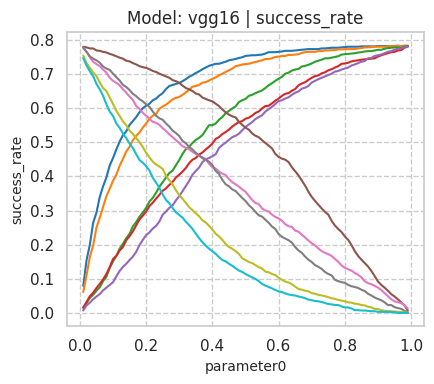

In [ ]:
label_list = ['success_rate']
# label_list = ['success_rate','attack_loss']
eta = 0.01
model_list = ['vgg16']
mask_mode_list = ['topr', 'channel_topr', 'lrp_topr','cam_topr','seed_randomr', 'seed_randomr_lowr', 'cam_lowr','lrp_lowr', 'channel_lowr', 'lowr']
plot_success_rate_vs_r1(data2, eta, 'fgsm', 'parameter0', label_list, model_list = model_list, mask_mode_list = mask_mode_list,nrows=1, ncols=1, output_path=data_root, save_name='vgg16_success_rate_vs_parameter0', if_legend = False)

In [15]:
data_root

'./data_stage3/one_step_attack_total1000_1107'

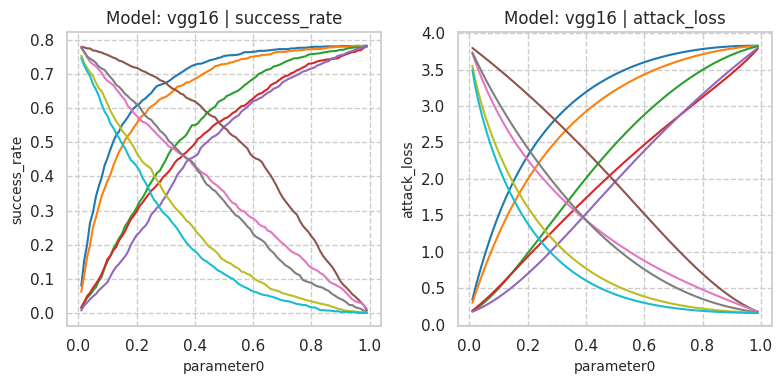

In [38]:
# label_list = ['success_rate']
eta = 0.01
plot_success_rate_vs_r(data2, eta, 'fgsm', 'parameter0', label_list, mask_mode_list=mask_mode_list, model_list = model_list, if_legend=False, output_path=data_root, save_name='vgg16_success_rate_vs_r0', nrows=1, ncols=2)

# 画出成功率与attack_loss、l1_norm、l2_norm的散点图

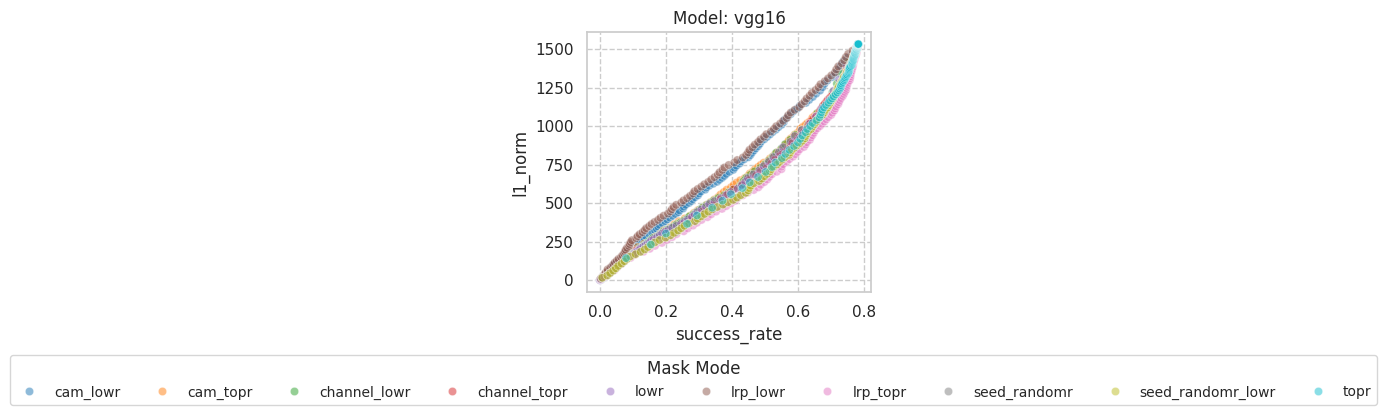

In [32]:
plot_loss_vs_pred_loss(data2, 0.01, 'fgsm',x='success_rate', y='l1_norm', model_list = model_list)

# 画出attack_loss和pred_loss的散点图

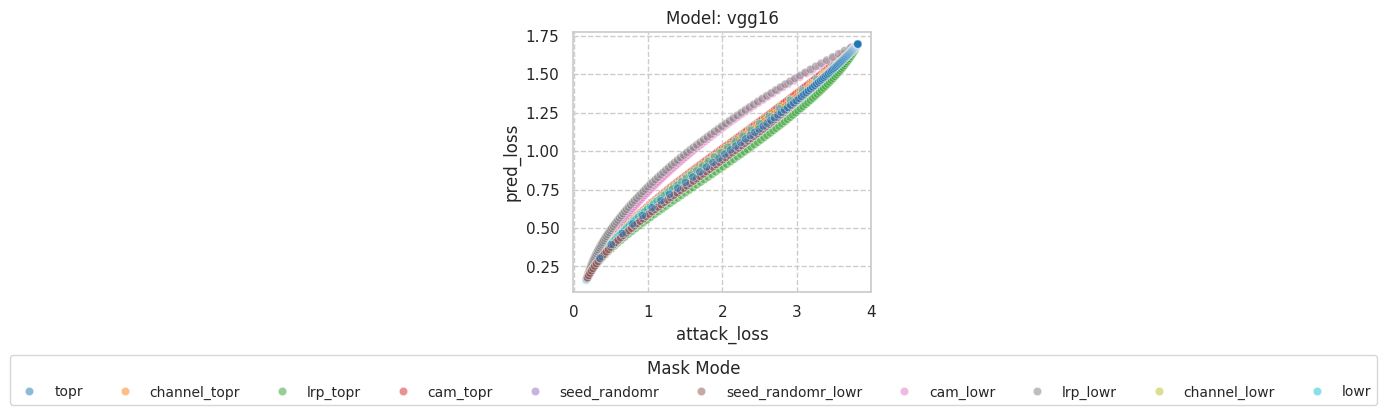

In [10]:
plot_loss_vs_pred_loss(data2, 0.01, 'fgsm', mask_mode_list=mask_mode_list, model_list = model_list)

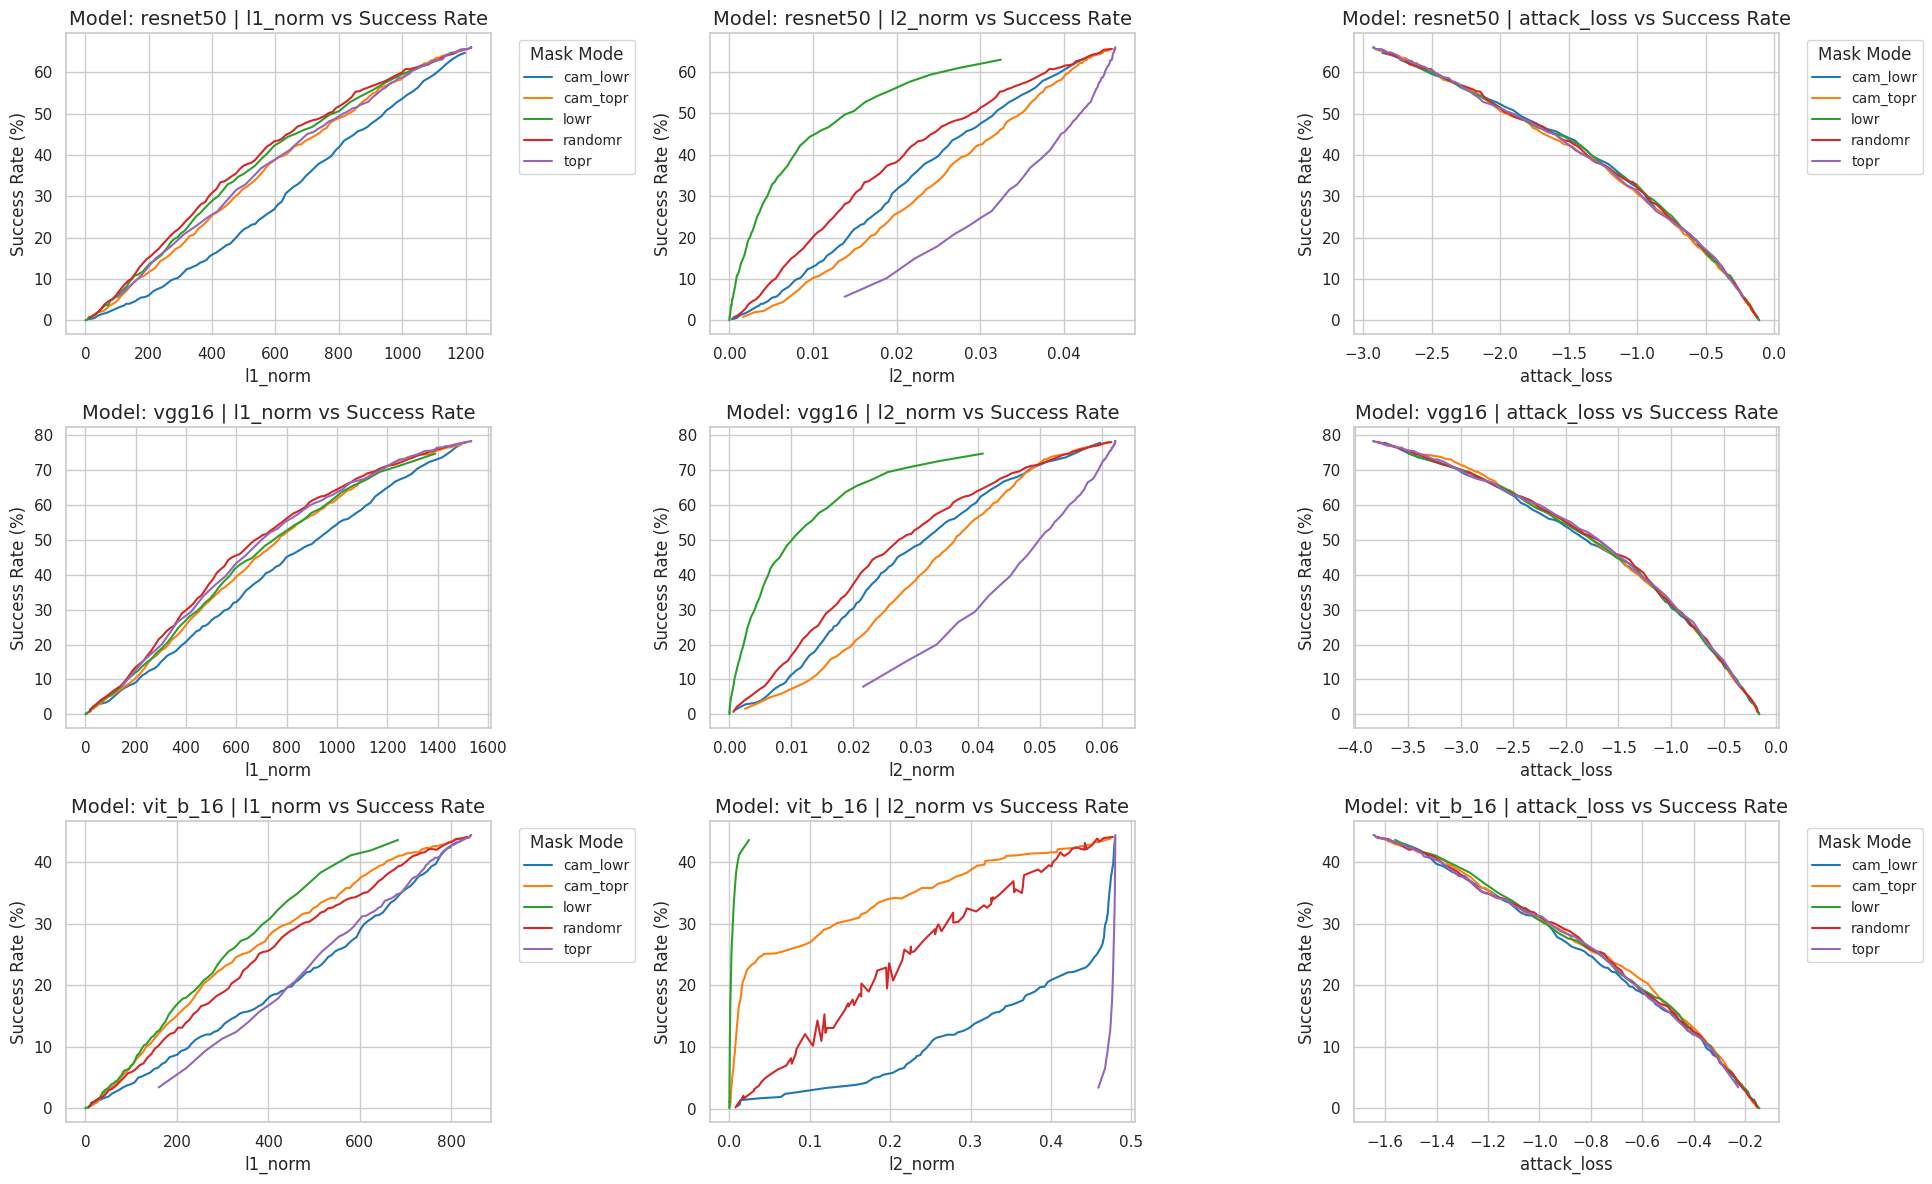

In [96]:
label_list = ['l1_norm', 'l2_norm', 'attack_loss']
plot_metrics_vs_success_rate_lines(data2, 0.01, 'fgsm', label_list, output_path=data_root, save_name='metrics_vs_success_rate_lines')

In [41]:
plot_3d_scatter_plotly(data2, 0.01, 'fgsm', 'l1_norm')

In [42]:
plot_3d_scatter_plotly(data2, 0.01, 'fgsm', 'l2_norm')